In [1]:
import sys

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

sys.path.insert(0, '/Users/williamjenkins/Research/Code/TritonOA/')

from tritonoa.kraken import KRAKENModelConfiguration, run_kraken
import tritonoa.plotting as plotting
from tritonoa.sp import ambiguity_function, normalize_pressure
from tritonoa.core import Top, Bottom, SoundSpeedProfile, Layer, Source, Receiver

## Calculate the received pressure field.

### View TL given source depth over depth and range.

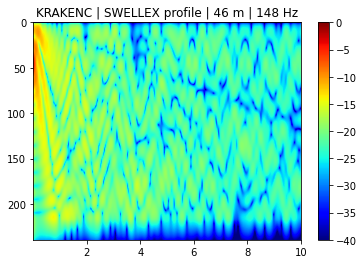

In [2]:
profile = "SWELLEX"
title = profile

top = Top()

layerdata = [
    {
        "z": [0, 217],
        "c_p": 1500.,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

layers = [Layer(SoundSpeedProfile(**kwargs)) for kwargs in layerdata]

bottom = Bottom(opt="A", z=layers[-1].z_max+1, c_p=5200, rho=2.7, a_p=0.03)

source = Source(46)
zvec = np.arange(0, layers[1].z_max, 0.5)
dr = 5 * 1e-3
rvec = np.arange(0, 10 + dr, dr)
receiver = Receiver(zvec, rvec)

freq = 148
clow = 1500
chigh = 1600

exp_actual = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
exp_actual.run(fldflag=True, model=model)
p_rec = exp_actual.modes.p
p_rec_norm = normalize_pressure(exp_actual.modes.p, log=True)

fig = plotting.plot_TL_2d(
    p_rec_norm,
    exp_actual.receiver.z,
    exp_actual.receiver.r,
    title=f"{model} | {profile} profile | {exp_actual.source.z.squeeze()} m | {freq} Hz"
)

### Set the parameters of the source.

In [3]:
depth_true = 46
range_true = 4.4
bot_c_p_true = 5200
bot_rho_true = 2.7

# ======================================================================
# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": [0, 217],
        "c_p": [1521.95, 1482],
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 1500
fixedparams["chigh"] = 1600

### Calculate received pressure field.

Text(0, 0.5, 'Depth [m]')

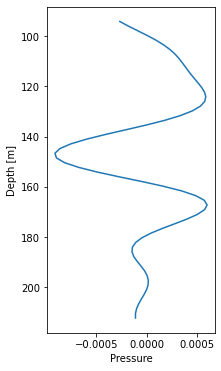

In [4]:
p_rec = run_kraken(fixedparams)

# Normalize pressure field
p_rec_norm = normalize_pressure(p_rec, log=True)

# Calculate covariance matrix
K = p_rec @ p_rec.conj().T

fig = plt.figure(figsize=(3, 6))
plt.plot(np.real(p_rec), fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.xlabel("Pressure")
plt.ylabel("Depth [m]")

## Perform Optimization

### Define search space

In [5]:
# ======================================================================
# ========================== FIXED PARAMETERS ==========================
# ======================================================================

# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": [0, 217],
        "c_p": [1521.95, 1482],
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200.
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
# fixedparams["rec_r"] = range_true


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 1500
fixedparams["chigh"] = 1600


# ======================================================================
# ============================ SEARCH SPACE ============================
# ======================================================================
parameters = [
    {
        "name": "rec_r",
        "type": "range",
        "bounds": [3., 6.],
        "value_type": "float"
    },
    # {
    #     "name": "src_z",
    #     "type": "range",
    #     "bounds": [10., 100.],
    #     "value_type": "float"
    # },
    # {
    #     "name": "bot_c_p",
    #     "type": "range",
    #     "bounds": [4000., 6000.],
    #     "value_type": "float"
    # },
    # {
    #     "name": "bot_rho",
    #     "type": "range",
    #     "bounds": [1.2, 4.],
    #     "value_type": "float"
    # }
]

### Matched Field Processing

In [6]:
dr = 5 / 1e3
rvec = np.arange(3, 6 + dr, dr)
zvec = np.arange(1, 211, 1)

pbar = tqdm(
    zvec,
    bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
    desc="MFP",
    leave=True,
    position=0,
    unit=" step"
)

p_rep = np.zeros((len(zvec), len(rvec), len(fixedparams["rec_z"])))
B_bart = np.zeros((len(zvec), len(rvec)))
for zz, z in enumerate(pbar):
    p_rep = run_kraken(fixedparams | {"src_z": z, "rec_r": rvec})    
    for rr, r in enumerate(rvec):
        B_bart[zz, rr] = ambiguity_function(K, p_rep[:, rr], atype="bartlett").item()

MFP: 100%|████████████████████| 210/210 [00:08<00:00, 24.20 step/s]


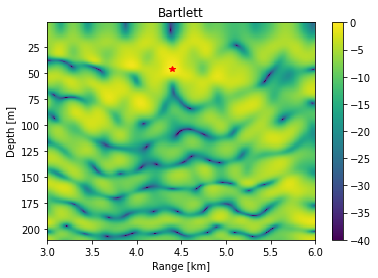

Text(0, 0.5, 'Bartlett Processor Output')

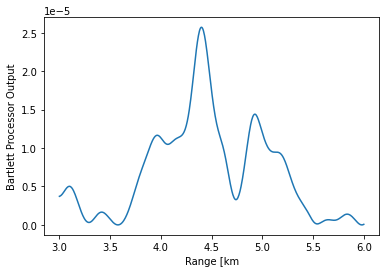

In [7]:
Bn = B_bart / np.max(B_bart)
logBn = 10 * np.log10(Bn)
src_z_ind, src_r_ind = np.unravel_index(np.argmax(logBn), (len(zvec), len(rvec)))
plt.imshow(
    logBn,
    aspect="auto",
    extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
    origin="lower",
    vmin=-40, vmax=0, interpolation="none")
plt.plot(rvec[src_r_ind], zvec[src_z_ind], 'r*')
plt.gca().invert_yaxis()
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title("Bartlett")
plt.colorbar()
plt.show()

plt.plot(rvec, B_bart[src_z_ind])
plt.xlabel("Range [km")
plt.ylabel("Bartlett Processor Output")

### Perform Bayesian optimization w/ Gaussian process

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# obj_type = "bartlett"

gs = GenerationStrategy(
    steps=[
        # 1. Initialization step (does not require pre-existing data and is well-suited for 
        # initial sampling of the search space)
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
            min_trials_observed=3, # How many trials need to be completed to move to next model
            max_parallelism=5,  # Max parallelism for this step
            model_kwargs={"seed": 999},  # Any kwargs you want passed into the model
            model_gen_kwargs={},  # Any kwargs you want passed to `modelbridge.gen`
        ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
            model_kwargs={"torch_device": device}
        ),
        # GenerationStep(
        #     model=Models.BO_MIXED,
        #     num_trials=-1,  # No limitation on how many trials should be produced from this step
        #     max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
        #     # More on parallelism vs. required samples in BayesOpt:
        #     # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        #     model_kwargs={"torch_device": device}
        # ),
    ]
)

ax_client = AxClient(generation_strategy=gs, verbose_logging=False)
ax_client.create_experiment(
    name="test_kraken",
    parameters=parameters,
    objective_name="bartlett",
    # minimize=True,  # Optional, defaults to False.
    # parameter_constraints=["x1 + x2 <= 2.0"],  # Optional.
    # outcome_constraints=["bartlett_const >= 0.0"],  # Optional.
)


def evaluate(parameters):
    p_rep = run_kraken(parameters)
    objective_raw = ambiguity_function(K, p_rep, atype="bartlett").item()
    return {"bartlett": (objective_raw, 0.)}


NITER = 30
pbar = tqdm(
    range(NITER),
    bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
    desc="BO",
    leave=True,
    position=0,
    unit="eval"
)

for i in pbar:
    searchparams, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(fixedparams | searchparams))

    best_trial, _, (best_obj, _) = ax_client.get_best_trial(
        use_model_predictions=False
    )
    pbar.set_postfix(
        {"Best Trial": best_trial} | \
        {k: v for k, v in searchparams.items()} | \
        {"obj": best_obj["bartlett"]}
    )


# best_parameters, (means, covariances) = ax_client.get_best_parameters()
# print(best_parameters)
# print(range_true, depth_true, bot_c_p_true, bot_rho_true)
# # print(means)

# render(ax_client.get_contour_plot())
# render(ax_client.get_optimization_trace())

[INFO 05-09 11:49:58] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='rec_r', parameter_type=FLOAT, range=[3.0, 6.0])], parameter_constraints=[]).
BO: 100%|████████████████████| 30/30 [00:06<00:00,  4.77eval/s, Best Trial=20, rec_r=4.4, obj=2.57e-5] 


In [14]:
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model

render(plot_slice(model, "rec_r", "bartlett"))

In [15]:
plot_config = plot_slice(model, "rec_r", "bartlett").data["data"]

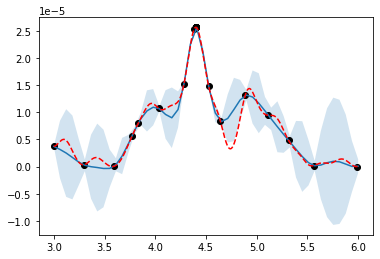

In [16]:
# Error
plt.fill_between(plot_config[0]["x"], plot_config[0]["y"], alpha=0.2)
# Mean
plt.plot(plot_config[1]["x"], plot_config[1]["y"])
# Evaluations
plt.scatter(plot_config[2]["x"], plot_config[2]["y"], c="k")
# Truth
plt.plot(rvec, B_bart[src_z_ind], "r--")

In [21]:
# import subprocess
from ax.plot.render import plot_config_to_html
from ax.utils.report.render import render_report_elements

# html = render_report_elements("Subsection with plot", "Example paragraph", header=True)
# subprocess.run("pbcopy", universal_newlines=True, input=html)


plot_config = plot_slice(model, "rec_r", "bartlett")
print(type(plot_config))

with open("report.html", "w") as f:
    f.write(
        render_report_elements(
            "example_report",
            html_elements=[plot_config_to_html(plot_config)],
            header=False
        )
    )



<class 'ax.plot.base.AxPlotConfig'>
